# Fisher LDA

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
import numpy as np
from scipy.stats import multivariate_normal

# Number of features of real valued random vector X 
features  = 4

# Number of samples to be generated for the vector
samples = 10000

# Initializing the mean and covariance matrix
mean = np.zeros((features,features))
mean[:,0] = [-1,-1,-1,-1] # Mean vector of class 0
mean[:,1] = [1,1,1,1] # Mean vector of class 1

cov = np.zeros((features, features, features))
cov[:,:,0] = [[2, -0.5, 0.3, 0], [-0.5, 1, -0.5, 0], [0.3, -0.5, 1, 0], [0,0,0,2]] # Covariance matrix of class 0
cov[:,:,1] = [[1, 0.3, -0.2, 0], [0.3, 2, 0.3, 0], [-0.2, 0.3, 1, 0], [0,0,0,3]] # Covariance matix of class 1

# Priors of Class 0 and 1

prior = [0.7, 0.3]

# Generating 10K samples of data 

label = np.zeros((features,samples))
label[0,:] = (np.random.uniform(0,1,samples) >= prior[0]).astype(int)

class0_count = float(list(label[0,:]).count(0))
class1_count = float(list(label[0,:]).count(1))

tpr = [] # True positive rate
fpr = [] # False positive rate
minPerror = [] # Minimum Error
gamma_list = []

X = np.zeros((features, samples))
for index in range(samples):
  if (label[0,index] == 0):
    X[:,index] = np.random.multivariate_normal(mean[:,0], cov[:,:,0],1)
  else:
    X[:, index] = np.random.multivariate_normal(mean[:,1],cov[:,:,1],1)

# list of threshold values 

q = list(sorted(X[0,:]))
for i in range(0,9999):
  gamma_list.append((q[i] + q[i+1])/2.0)
gamma_list = [gamma_list[i] for i in range(0,len(gamma_list)) if gamma_list[i]>=0]

# Calculate the discriminant score 
logValpdf1 = np.log(multivariate_normal.pdf(X.T, mean=mean[:,1], cov= cov[:,:,1]))
logValpdf0 = np.log(multivariate_normal.pdf(X.T, mean=mean[:,0], cov= cov[:,:,0]))
discriminant_score = logValpdf1-logValpdf0


# Calculate the probability of minimum error for all values in gamma_list
for gamma in gamma_list:
  label[1,:] = (discriminant_score >= np.log(gamma)).astype(int)
  x00 = [i for i in range(label.shape[1]) if (label[1,i] == 0 and label[0,i] == 0)]
  x01 = [i for i in range(label.shape[1]) if (label[1,i] == 0 and label[0,i] == 1)]
  x10 = [i for i in range(label.shape[1]) if (label[1,i] == 1 and label[0,i] == 0)]
  x11 = [i for i in range(label.shape[1]) if (label[1,i] == 1 and label[0,i] == 1)]
  fpr.append(len(x10)/class0_count)
  tpr.append(len(x11)/class1_count)
  minPerror.append(1 - ((len(x00)+len(x11))/10000.0)) 

x0 = [i for i in range(label.shape[1]) if (label[0,i] == 0)]
x1 = [i for i in range(label.shape[1]) if (label[0,i] == 1 )]

In [ ]:
#Calculate the Sb Matrix
Sb = np.dot((mean[:,0] - mean[:,1]), (mean[:,0] - mean[:,1]).T)
# Calculate the Sw Matrix
Sw = (cov[:,:,0] + cov[:,:,1])
# Calculation of W_lda
a,b =np.linalg.eig(np.dot(np.linalg.inv(Sw),Sb))
np.dot(np.linalg.inv(Sw),Sb)
w = np.array(b[np.argmax(a)])
# x0 = [i for i in range(label.shape[1]) if (label[0,i] == 0)]
# x1 = [i for i in range(label.shape[1]) if (label[0,i] == 1 )]
# Calculation of Projection vector
y0 = np.zeros((2,len(x0)))
y1 = np.zeros((2,len(x1)))
y0[0,:] = np.dot(w.T, X[:,x0])
y1[0,:] = np.dot(w.T, X[:,x1])
y = np.sort(np.hstack((y0[0],y1[0])))

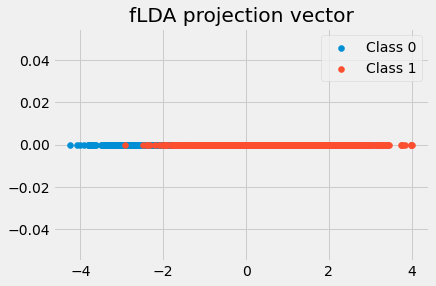

In [ ]:
# Plot the Projection vector
plt.scatter(y0[0,:],np.zeros((y0.shape[1])))
plt.scatter(y1[0,:],np.zeros((y1.shape[1])))
plt.legend(['Class 0','Class 1'])
plt.title('fLDA projection vector')
plt.show()

In [ ]:
# Calculate Threshold values
a = []
for i in range(len(y)-1):
  a.append((y[i] + y[i+1])/2.0)
# Calculate decisions for varying thresholds
fpr = []
tpr = []
minPerror = []
for threshold in a:
  x00 = list((y0[0,:] >= threshold).astype(int)).count(0)
  x01 = list((y1[0,:] >= threshold).astype(int)).count(0)
  x10 = list((y0[0,:] >= threshold).astype(int)).count(1)
  x11 = list((y1[0,:] >= threshold).astype(int)).count(1)
  fpr.append(float(x10)/y0.shape[1])
  tpr.append(float(x11)/y1.shape[1])
  minPerror.append(1 - ((x00)+(x11))/10000.0)

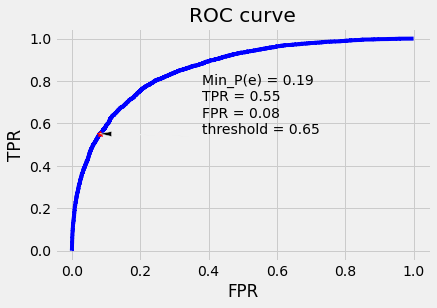

In [ ]:
# Plot the ROC curve
plt.plot(fpr,tpr,color = 'blue' )
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(fpr[np.argmin(minPerror)],tpr[np.argmin(minPerror)],'*',color = 'red')
plt.title("ROC curve")
plt.annotate(s='Min_P(e) = ' + str(round(minPerror[np.argmin(minPerror)],3)) + '\n'
+'TPR = '+ str(round(tpr[np.argmin(minPerror)],2)) + '\n'
+'FPR = '+ str(round(fpr[np.argmin(minPerror)],2)) + '\n'
+'threshold = '+ str(round(a[np.argmin(minPerror)],2)),xy
=(fpr[np.argmin(minPerror)],tpr[np.argmin(minPerror)]),
xytext=(fpr[np.argmin(minPerror)]+0.3,tpr[np.argmin(minPerror)]),
arrowprops=dict(facecolor='black', width = 0.01,headwidth = 5,shrink=0))
plt.show()